<a href="https://colab.research.google.com/github/Alamsyah-WM/Predict-DNA-binding-protein-with-ML-and-DL/blob/main/BioInformatik_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup Environment

In [ ]:
!pip install biopython modlamp numpy pandas matplotlib seaborn scikit-learn #Packages

##Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# BioInformatic & Featured Tools
from Bio.SeqUtils.ProtParam import ProteinAnalysis # For calculate amino acid, hydrophobic, charge
from modlamp.descriptors import GlobalDescriptor # For global descriptor above

# Ml preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit #For split dataset
from sklearn.preprocessing import StandardScaler # FOr normalization
from sklearn.svm import SVC # For model classifier
from sklearn.neural_network import MLPClassifier # For MLP Classifer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, confusion_matrix, RocCurveDisplay
) # For evaluate

np.random.seed(42)
random.seed(42)

#**EDA**
##Objective
1. Load Dataset
2. Dataset Cleaning
3. Sequence length distribution & Class balance
4. Amino Acid Composition
5. Physicochemical Descriptors
6. k-mer Example

###1. Load Dataset

In [134]:
# Define variable for each path
pdb_path = "/content/PDB1063-186.csv"
uni_path = "/content/UniSwiss.csv"

# Define variable for read csv file into pandas dataframe
pdb_df = pd.read_csv(pdb_path)
uni_df = pd.read_csv(uni_path)

# Get dataset df/dataframe
print("PDB1063 shape:", pdb_df.shape)
print("UniSwiss shape:", uni_df.shape)

# Get dataset column name
print("\nPDB1063 columns:", pdb_df.columns.tolist())
print("UniSwiss columns:", uni_df.columns.tolist())

# Get top 3 dataframe for each dataset
print(pdb_df.head(3))
print(uni_df.head(3))



PDB1063 shape: (1249, 4)
UniSwiss shape: (9762, 4)

PDB1063 columns: ['identifier', 'sequence', 'label', 'set']
UniSwiss columns: ['identifier', 'sequence', 'label', 'set']
  identifier                                           sequence  label    set
0      1AKHB  TKPYRGHRFTKENVRILESWFAKNIENPYLDTKGLENLMKNTSLSR...      1  train
1      1B6WA  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...      1  train
2      1C1KA  MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVS...      1  train
  identifier                                           sequence  label    set
0     P08956  MMNKSNFEFLKGVNDFTYAIACAAENNYPDDPNTTLIKMRMFGEAT...      1  train
1     P27235  MPPQRSRRRKRASATQLYQTCKASGTCPPDVIPKVEGTTLADKILQ...      1  train
2     P0AD01  MINVLIIDDDAMVAELNRRYVAQIPGFQCCGTASTLEKAKEIIFNS...      1  train


###2. Dataset cleaning

In [135]:
# Get information about the datasets
print("\nMissing Values in PDB Dataset:")
print(pdb_df.isnull().sum())
print("\nMissing Values in UniSwiss Dataset:")
print(uni_df.isnull().sum())

# Clean duplicates dataset
# Convert to uppercase and remove invalid amino acids
valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
def clean_sequence(seq):
    if not isinstance(seq, str):
        return ""
    seq = seq.strip().upper()
    return ''.join([a for a in seq if a in valid_aa])

pdb_df["sequence"] = pdb_df["sequence"].apply(clean_sequence)
uni_df["sequence"] = uni_df["sequence"].apply(clean_sequence)

# Get total sequence before clean
print("\nBefore duplicate cleaning:")
print(f"PDB total rows: {len(pdb_df)}, unique sequences: {pdb_df['sequence'].nunique()}")
print(f"UniSwiss total rows: {len(uni_df)}, unique sequences: {uni_df['sequence'].nunique()}")

# Drop duplicate sequence
pdb_df = pdb_df.drop_duplicates(subset=["sequence", "label"], keep="first").reset_index(drop=True)
uni_df = uni_df.drop_duplicates(subset=["sequence", "label"], keep="first").reset_index(drop=True)

pdb_df["seq_len"] = pdb_df["sequence"].str.len()
uni_df["seq_len"] = uni_df["sequence"].str.len()

pdb_df = pdb_df[pdb_df["seq_len"] > 0].dropna(subset=["sequence", "label"])
uni_df = uni_df[uni_df["seq_len"] > 0].dropna(subset=["sequence", "label"])

print(f"PDB1063 shape: {pdb_df.shape}")
print(f"UniSwiss shape: {uni_df.shape}")

print("\nUnique sequences after cleaning:")
print("Total Non-dups PDB:", pdb_df['sequence'].nunique())
print("Total Non-dups UniSwiss:", uni_df['sequence'].nunique())



Missing Values in PDB Dataset:
identifier    0
sequence      0
label         0
set           0
dtype: int64

Missing Values in UniSwiss Dataset:
identifier    0
sequence      0
label         0
set           0
dtype: int64

Before duplicate cleaning:
PDB total rows: 1249, unique sequences: 1171
UniSwiss total rows: 9762, unique sequences: 9696
PDB1063 shape: (1171, 5)
UniSwiss shape: (9697, 5)

Unique sequences after cleaning:
Total Non-dups PDB: 1171
Total Non-dups UniSwiss: 9696


###3. Sequence length distribution & Class balance

Total PDB Sequence: 1207
Total Uniswiss Sequence: 9762

Average PDB Sequence Length: 241
Average Uniswiss Sequence Length: 475

Median PDB Sequence Length: 192.0
Median UniSwiss Sequence Length: 356.0

Std Dev PDB Sequence Length: 178.13
Std Dev UniSwiss Sequence Length: 462.31

Minimum PDB Sequence Length: 50
Maximum PDB Sequence Length: 1323

Minimum Uniswiss Sequence Length: 49
Maximum Uniswiss Sequence Length: 8515

Label Distribution in PDB Dataset:
label
0    638
1    569
Name: count, dtype: int64

Label Distribution in UniSwiss Dataset:
label
1    4881
0    4881
Name: count, dtype: int64


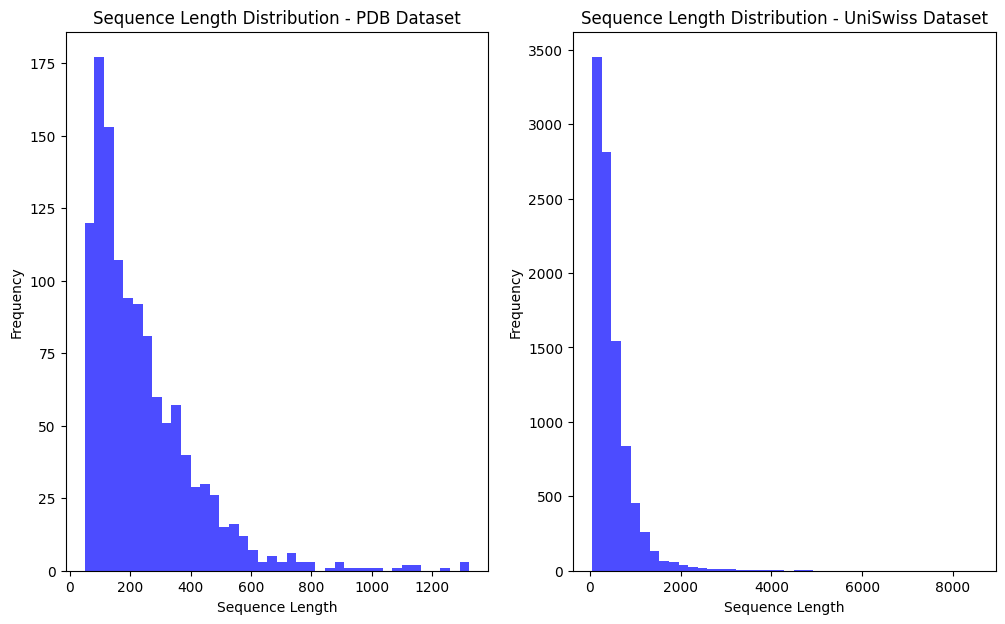

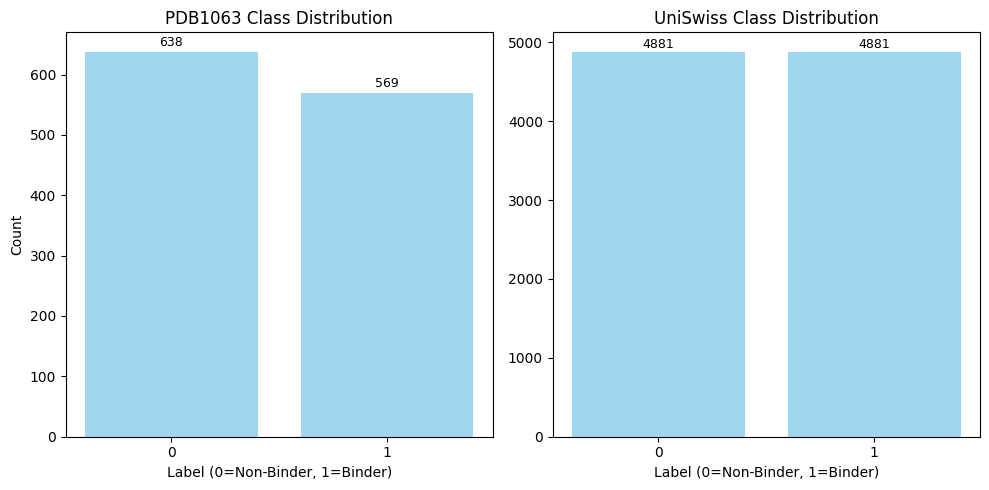

In [117]:
# Count the label distribution balances
pdb_label_counts = pdb_df['label'].value_counts()
uni_label_counts = uni_df['label'].value_counts()

# Get sequence length detail for each dataset
print("Total PDB Sequence:", len(pdb_df))
print("Total Uniswiss Sequence:", len(uni_df))

print("\nAverage PDB Sequence Length:", int(pdb_df['seq_len'].mean()))
print("Average Uniswiss Sequence Length:", int(uni_df['seq_len'].mean()))

print("\nMedian PDB Sequence Length:", round(pdb_df['seq_len'].median(), 2))
print("Median UniSwiss Sequence Length:", round(uni_df['seq_len'].median(), 2))

print("\nStd Dev PDB Sequence Length:", round(pdb_df['seq_len'].std(), 2))
print("Std Dev UniSwiss Sequence Length:", round(uni_df['seq_len'].std(), 2))

print("\nMinimum PDB Sequence Length:", pdb_df['seq_len'].min())
print("Maximum PDB Sequence Length:", pdb_df['seq_len'].max())

print("\nMinimum Uniswiss Sequence Length:", uni_df['seq_len'].min())
print("Maximum Uniswiss Sequence Length:", uni_df['seq_len'].max())

print("\nLabel Distribution in PDB Dataset:")
print(pdb_label_counts)
print("\nLabel Distribution in UniSwiss Dataset:")
print(uni_label_counts)


# Visualize protein using histogram.
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.hist(pdb_df['seq_len'], bins=40, alpha=0.7, color='blue')
plt.title('Sequence Length Distribution - PDB Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(uni_df['seq_len'], bins=40, alpha=0.7, color='blue')
plt.title('Sequence Length Distribution - UniSwiss Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

# Counts total DNA binders (1) and non-binders (0) exist for both dataset.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pdb_counts_label = pdb_df['label'].value_counts().sort_index()
axes[0].bar(pdb_counts_label.index.astype(str), pdb_counts_label.values, color='skyblue', alpha=0.8)
axes[0].set_title("PDB1063 Class Distribution")
axes[0].set_xlabel("Label (0=Non-Binder, 1=Binder)")
axes[0].set_ylabel("Count")
for i, v in enumerate(pdb_counts_label.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontsize=9)

uni_counts_label = uni_df['label'].value_counts().sort_index()
axes[1].bar(uni_counts_label.index.astype(str), uni_counts_label.values, color='skyblue', alpha=0.8)
axes[1].set_title("UniSwiss Class Distribution")
axes[1].set_xlabel("Label (0=Non-Binder, 1=Binder)")
for i, v in enumerate(uni_counts_label.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

###4. Amino Acid Composition

/usr/local/lib/python3.12/dist-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


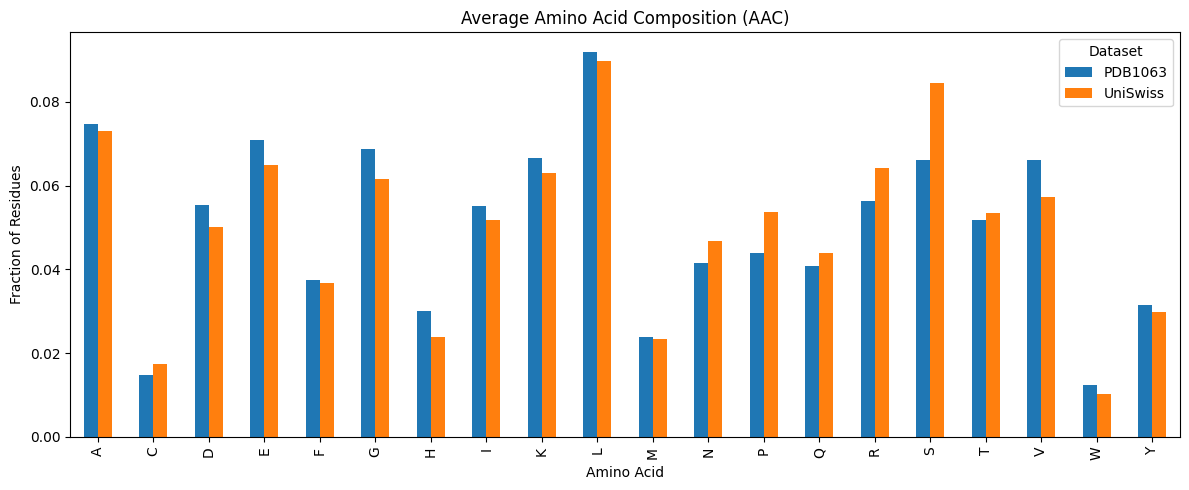

In [ ]:
# Function with ACC Composition method
def asam_amino_composition(seq):
    analysed_seq = ProteinAnalysis(seq)
    return analysed_seq.get_amino_acids_percent()

# Convert list of dicts to DataFrame, then take mean across all proteins.
pdb_aac_mean = pd.DataFrame(pdb_df["sequence"].apply(lambda s: asam_amino_composition(s)).tolist()).mean()
uni_aac_mean = pd.DataFrame(uni_df["sequence"].apply(lambda s: asam_amino_composition(s)).tolist()).mean()

# Visualize chart for both dataset.
aac_df = pd.DataFrame({"PDB1063": pdb_aac_mean, "UniSwiss": uni_aac_mean})
aac_df.plot(kind="bar", figsize=(12, 5))
plt.title("Average Amino Acid Composition (AAC)")
plt.ylabel("Fraction of Residues")
plt.xlabel("Amino Acid")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


###5. Physicochemical Descriptors

In [ ]:
def dipeptide_freq(seq):
    """
    Compute normalized dipeptide (k=2) frequencies for all possible pairs.
    Result is a dict with 400 keys (20x20 combinations).
    """
    from itertools import product
    aas = "ACDEFGHIKLMNPQRSTVWY"       # 20 standard amino acids
    k2 = ["".join(p) for p in product(aas, repeat=2)]  # All dipeptides
    counts = {dp: 0 for dp in k2}      # Initialize counts
    for i in range(len(seq) - 1):      # Iterate through sequence pairs
        dp = seq[i:i+2]
        if dp in counts:
            counts[dp] += 1
    total = sum(counts.values())

    return {k: v/total for k, v in counts.items() if total > 0}

#**Pre-Process**
##Objective
1. Split Dataset
2. Scaling


###1. Split Dataset

In [ ]:
# Count total set distribution for split
pdb_set_counts = pdb_df['set'].value_counts()
pdb_set_percentage = (pdb_set_counts / len(pdb_df)) * 100 #Calculate into percentage
uniswiss_set_counts = uni_df['set'].value_counts()
uniswiss_set_percentage = (uniswiss_set_counts / len(uni_df)) * 100 #Calculate into percentage

print("\nRaw PDB Dataset split:")
print(pdb_set_counts)
print(pdb_set_percentage)

print("\nRaw UniSwiss Dataset Split:")
print(uniswiss_set_counts)
print(uniswiss_set_percentage)


Raw PDB Dataset split:
set
train    1063
test      186
Name: count, dtype: int64
set
train    85.108086
test     14.891914
Name: count, dtype: float64

Raw UniSwiss Dataset Split:
set
train    9000
test      762
Name: count, dtype: int64
set
train    92.194222
test      7.805778
Name: count, dtype: float64
